<a href="https://colab.research.google.com/github/dpant/TensorFlow/blob/main/Course3-NLP/ClassifyTweetsSentiments-GloveEmbedding100d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
nltk.download('book')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import sklearn

import codecs
from tqdm import tqdm

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2000.zip.
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2002.zip.
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/dependency_treebank.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    

In [2]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv



--2021-07-15 19:40:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  64.0MB/s    in 3.6s    

2021-07-15 19:40:57 (64.0 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [3]:
raw = pd.read_csv('/tmp/training_cleaned.csv', header=None)

In [4]:
raw.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Sampling raw dataset

In [5]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [6]:
df = stratified_sample_df(raw, 0, 100000).reset_index(drop=True)
df

,0,1,2,3,4,5
0,0,2049700865,Fri Jun 05 17:20:38 PDT 2009,NO_QUERY,slimmchic,Looks like I might be staying in tonight
1,0,2204478937,Wed Jun 17 02:19:30 PDT 2009,NO_QUERY,Tbird8057,Earlier no reason wakeup yet again
2,0,1556810238,Sun Apr 19 00:27:26 PDT 2009,NO_QUERY,potatofarmgirl,I had really weird nightmares where I was a gh...
3,0,1563638829,Sun Apr 19 23:37:33 PDT 2009,NO_QUERY,ENITSIRHCNGUYEN,"Trying to finish last minute homework, speeche..."
4,0,2233060133,Thu Jun 18 20:46:37 PDT 2009,NO_QUERY,kieunga,I want to twit on computer. But I'm afraid dad...
...,...,...,...,...,...,...
199995,4,1833999579,Mon May 18 01:14:33 PDT 2009,NO_QUERY,matrixster,Last's week's mechanics - police racas I got t...
199996,4,2190701141,Tue Jun 16 03:29:02 PDT 2009,NO_QUERY,Runawaysoul,"@crissangel Sleep well, Criss! Thanks so much ..."
199997,4,2014390629,Wed Jun 03 01:22:22 PDT 2009,NO_QUERY,xo_nessa,@HayleySmith16 afternoon
199998,4,2062725079,Sun Jun 07 00:05:58 PDT 2009,NO_QUERY,patvandiest,@alephdmc yaay! I'm waiting 15.00 WIB on CNBC ...


## Cleaning dataset

In [7]:
df.rename(columns = {0:'target', 5:'text'}, inplace = True)

In [8]:
df = df.drop([1, 2, 3, 4], axis=1)

In [9]:
df.head()

,target,text
0,0,Looks like I might be staying in tonight
1,0,Earlier no reason wakeup yet again
2,0,I had really weird nightmares where I was a gh...
3,0,"Trying to finish last minute homework, speeche..."
4,0,I want to twit on computer. But I'm afraid dad...


## Pre-proccessing text

In [10]:
df_preprocess = df.copy()

In [11]:
tweets = df_preprocess.text.copy()

In [12]:
tweets

0                 Looks like I might be staying in tonight 
1                       Earlier no reason wakeup yet again 
2         I had really weird nightmares where I was a gh...
3         Trying to finish last minute homework, speeche...
4         I want to twit on computer. But I'm afraid dad...
                                ...                        
199995    Last's week's mechanics - police racas I got t...
199996    @crissangel Sleep well, Criss! Thanks so much ...
199997                            @HayleySmith16 afternoon 
199998    @alephdmc yaay! I'm waiting 15.00 WIB on CNBC ...
199999              @rulette awesome, see you there  #140tc
Name: text, Length: 200000, dtype: object

### Remove hashtags, @ and url

In [13]:
def removeWordWithChar(text, char_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    res = [ele for ele in text if all(ch not in ele for ch in char_list)]
    res = ' '.join(res)
    return res

char_list = ['@', '#', 'http', 'www', '/']

removeWordWithChar(tweets[1], char_list)

'Earlier no reason wakeup yet again'

In [14]:
tweets_cleaned = []
for t in tweets:
    tweets_cleaned.append(removeWordWithChar(t, char_list))

In [15]:
tweets_cleaned[0]

'Looks like I might be staying in tonight'

In [16]:
len(tweets_cleaned)

200000

### Tokenize

In [17]:
def tokenize(texts):
    tokenizer = nltk.RegexpTokenizer(r'\w+')

    texts_tokens = []
    for i, val in enumerate(texts):
        text_tokens = tokenizer.tokenize(val.lower())

        for i in range(len(text_tokens) - 1, -1, -1):
            if len(text_tokens[i]) < 4:
                del(text_tokens[i])

        texts_tokens.append(text_tokens)
        
    return texts_tokens

In [18]:
tweets_tokens = tokenize(tweets_cleaned)

tweets_tokens[:]

[['looks', 'like', 'might', 'staying', 'tonight'],
 ['earlier', 'reason', 'wakeup', 'again'],
 ['really',
  'weird',
  'nightmares',
  'where',
  'ghost',
  'during',
  'alaskan',
  'goldrush',
  'fighting',
  'aliens',
  'ufos',
  'thanks',
  'alot',
  'pepperoni',
  'pizza'],
 ['trying',
  'finish',
  'last',
  'minute',
  'homework',
  'speeches',
  'spring',
  'break',
  'over'],
 ['want',
  'twit',
  'computer',
  'afraid',
  'come',
  'home',
  'suddenly',
  'then',
  'awkwardly'],
 ['more',
  'week',
  'graduation',
  'watch',
  'things',
  'fast',
  'know',
  'were',
  'seperating'],
 ['that', 'statue', 'liberty', 'there', 'late', 'catch', 'last', 'ferry'],
 ['morning',
  'going',
  'windermere',
  'today',
  'last',
  'holiday',
  'great',
  'time',
  'though',
  'feeling'],
 ['school'],
 ['lack', 'sleep', 'monday', '800m', 'today'],
 ['tomorrow', 'morning', 'going', 'come', 'quickly', 'tired'],
 ['really',
  'disappointing',
  'response',
  'blog',
  'radio',
  'show',
  'quo

### Stopwords

In [19]:
def removeSW(texts_tokens):
    stopWords = set(stopwords.words('english'))
    texts_filtered = []

    for i, val in enumerate(texts_tokens):
        text_filtered = []
        for w in val:
            if w not in stopWords:
                text_filtered.append(w)
        texts_filtered.append(text_filtered)
        
    return texts_filtered

In [20]:
tweets_filtered = removeSW(tweets_tokens)

tweets_filtered[:1]

[['looks', 'like', 'might', 'staying', 'tonight']]

### Lemma

In [21]:
def lemma(texts_filtered):
    wordnet_lemmatizer = WordNetLemmatizer()
    texts_lem = []

    for i, val in enumerate(texts_filtered):
        text_lem = []
        for word in val:
            text_lem.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        texts_lem.append(text_lem)
    
    return texts_lem

In [22]:
nltk.download('wordnet')

tweets_lem = lemma(tweets_filtered)

tweets_lem[:1]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[['look', 'like', 'might', 'stay', 'tonight']]

In [23]:
tweets_ready = []
for tweet in tweets_lem:
    string = ' '
    string = string.join(tweet)
    tweets_ready.append(string)

In [24]:
len(tweets_ready)

200000

In [25]:
df_preprocess['tweet'] = tweets_ready
df_preprocess['target'] = df.target.replace(4, 1)

In [26]:
df_preprocess

,target,text,tweet
0,0,Looks like I might be staying in tonight,look like might stay tonight
1,0,Earlier no reason wakeup yet again,earlier reason wakeup
2,0,I had really weird nightmares where I was a gh...,really weird nightmares ghost alaskan goldrush...
3,0,"Trying to finish last minute homework, speeche...",try finish last minute homework speeches sprin...
4,0,I want to twit on computer. But I'm afraid dad...,want twit computer afraid come home suddenly a...
...,...,...,...
199995,1,Last's week's mechanics - police racas I got t...,last week mechanics police racas inhale tearga...
199996,1,"@crissangel Sleep well, Criss! Thanks so much ...",sleep well criss thank much keep update love k...
199997,1,@HayleySmith16 afternoon,afternoon
199998,1,@alephdmc yaay! I'm waiting 15.00 WIB on CNBC ...,yaay wait cnbc see conan tonight show


## Word embedding : Glove

In [27]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt  -O /tmp/glove.6B.100d.txt
GLOVE_EMB = '/tmp/glove.6B.100d.txt'
EMBEDDING_DIM = 100


--2021-07-15 19:41:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-07-15 19:41:13 ERROR 404: Not Found.



In [28]:
##Glove embedding 300d
#!wget --no-check-certificate  https://nlp.stanford.edu/data/glove.42B.300d.zip  -O /tmp/glove.42B.300d.zip
#! unzip  /tmp/glove.42B.300d.zip
#! mv glove.42B.300d.txt /tmp
#GLOVE_EMB = '/tmp/glove.42B.300d.txt'
#EMBEDDING_DIM = 300

In [29]:
%%time
embeddings_index = {}
f = codecs.open(GLOVE_EMB, encoding='utf-8')
for line in tqdm(f):
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

0it [00:00, ?it/s]

Found 0 word vectors.
CPU times: user 5.24 ms, sys: 1.03 ms, total: 6.27 ms
Wall time: 10 ms


In [30]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocess.tweet)

word_index = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocabulary_size)

Vocabulary Size : 66294


In [31]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [32]:
embedding_matrix.shape

(66294, 100)

## Prepare training

In [33]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [34]:
BATCH_SIZE = 1024
EPOCHS = 30

### Create train / test sets

In [35]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_preprocess['tweet'], df_preprocess['target'], test_size=0.2, random_state=123)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 160000
Test Data size 40000


In [36]:
MAX_SEQUENCE_LENGTH = 30

In [37]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (160000, 30)
Testing X Shape: (40000, 30)


### Embedding layer

In [38]:
embedding_matrix.shape

(66294, 100)

In [39]:
embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

### Callbacks

In [40]:
es=EarlyStopping(monitor='val_loss',
                 mode='min',
                 verbose=1,
                 patience=5)

reduce_lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

## Model A : CNN

In [41]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer(inputs)
x = Dropout(0.5)(x)

# Conv1D x2 + global max pooling
x = Conv1D(128, 7, activation="relu")(x)
x = Conv1D(128, 7, activation="relu")(x)
x = GlobalMaxPooling1D()(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_A = tf.keras.Model(inputs, outputs)

In [42]:
model_A.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 100)           6629400   
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 128)           89728     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 128)           114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               66048 

In [43]:
model_A.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
%%time
history_A = model_A.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 18s 12ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.4992
Epoch 2/30
157/157 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.4992
Epoch 3/30
157/157 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 4/30
157/157 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.4992
Epoch 5/30
157/157 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 6/30
157/157 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.4992
Epoch 7/30
157/157 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.499

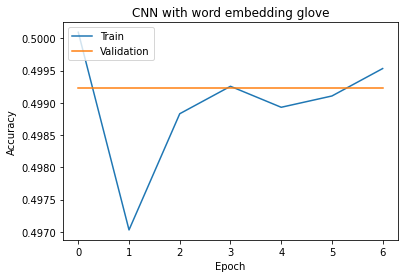

In [45]:
plt.plot(history_A.history['accuracy'])
plt.plot(history_A.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('CNN with word embedding glove')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

## Model B : RNN

In [46]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer(inputs)
x = SpatialDropout1D(0.2)(x)

# Conv1D + LSTM (bidirectional)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_B = tf.keras.Model(inputs, outputs)

In [47]:
model_B.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 100)           6629400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 64)            32064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0   

In [48]:
model_B.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
%%time
history_B = model_B.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 45s 258ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5008
Epoch 2/30
157/157 [==============================] - 41s 264ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5008
Epoch 3/30
157/157 [==============================] - 40s 257ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 4/30
157/157 [==============================] - 40s 255ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.4992
Epoch 5/30
157/157 [==============================] - 40s 255ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 6/30
157/157 [==============================] - 39s 250ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5008
Epoch 7/30
157/157 [==============================] - 41s 260ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_ac

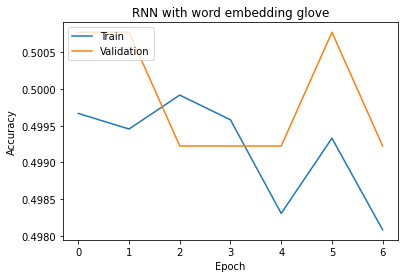

In [50]:
plt.plot(history_B.history['accuracy'])
plt.plot(history_B.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('RNN with word embedding glove')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')